In [1]:
# add folders to Python's search space
import os, sys
from pathlib import Path
script_dir = Path(os.path.dirname(os.path.abspath('')))
module_dir = str(script_dir.parent.parent)
sys.path.insert(0, module_dir + '/non-grad3D/modules')
print(module_dir)

# import the rest of the modules
%matplotlib nbagg
%matplotlib inline
import numpy as np
import tensorflow as tf 
import matplotlib.pyplot as plt
import arch
import pandas as pd
import tensorflow_probability as tfp
import time  
import sim
from mpl_toolkits.axes_grid1 import make_axes_locatable
DTYPE = 'float32'

C:\Users\pinak\Documents\GitHub


In [2]:
# load learned solution
dim = 3
net = arch.LSTMForgetNet(50, 3, tf.float32, name="L63")
net.load_weights('../../../non-grad3D/data/L63/1M/{}'.format(net.name)).expect_partial()
X = tf.random.uniform(shape=(10, dim))
net(*tf.split(X, dim, axis=-1))

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[2.4211497],
       [2.711165 ],
       [2.4840198],
       [2.6383967],
       [2.6060748],
       [2.56756  ],
       [2.644964 ],
       [2.6202207],
       [2.4198034],
       [2.4788644]], dtype=float32)>

In [45]:
# compute Monte-Carlo estimate
dim = 3
n_particles = int(5e6)
n_subdivisions = 100
n_int_subdivs = 1000
save_folder = '../../../non-grad3D/data/L63'
n_steps = 1000
n_repeats = 100
dt = 0.01
alpha, beta, rho = 10., 8./3., 28.
sigma = 10.
D = sigma**2 / 2.
t = dt * n_steps
r = 1.0
# low=[-20., -20., -20.]
# high=[20., 30., 80.]
# domain = [low, high]

def mu_np(X):
    x, y, z = np.split(X, dim, axis=-1)
    p = alpha * (y - x) 
    q = x * (rho - z) - y 
    r = x * y - beta * z
    return np.concatenate([p, q, r], axis=-1)


X0 =  tfp.distributions.MultivariateNormalDiag(scale_diag=r*tf.ones(dim)).sample(n_particles).numpy()
mc_prob = sim.MCProb(save_folder, n_subdivisions, mu_np, sigma, X0, tick_size=20, title_size=20, cbar_tick_size=15)
mc_prob.ready(n_steps=n_steps, dt=dt, lims=None)
#mc_prob.compute_all(n_steps=n_steps, dt=dt)

Time taken by propagate is 489.59868001937866 seconds
Time taken by set_grid is 19.407071113586426 seconds
Time taken by assign_pts is 22.651958465576172 seconds
Time taken by ready is 531.6597127914429 seconds


In [43]:
# set up plotting parameters
scale = 10
xlabel_size = ylabel_size = 15 + scale
tick_size = 10 + scale
legend_size = 15 + scale
title_size = 15 + scale
cbar_tick_size = 10 + scale

In [41]:
# projecter for 3D to 2D
def projector(net, low, high, idx, n_subdivs, n_int_subdivs, dtype='float32'):
  x = np.linspace(low[idx[0]], high[idx[0]], num=n_subdivs+1, endpoint=True).astype(dtype)[1:]
  y = np.linspace(low[idx[1]], high[idx[1]], num=n_subdivs+1, endpoint=True).astype(dtype)[1:]
  z = np.linspace(low[idx[2]], high[idx[2]], num=n_int_subdivs+1, endpoint=True).astype(dtype).reshape(-1, 1)
  delta = (high[idx[0]] - low[idx[0]]) * (high[idx[1]] - low[idx[1]]) / (n_subdivs)**2
  delta_z = (high[idx[2]] - low[idx[2]]) / n_int_subdivs
  weights = np.ones_like(z) 
#   for iw, w in enumerate(weights):
#     if iw % 2 == 0 and iw > 0:
#       weights[iw][0] = 2. 
#     else:
#       weights[iw][0] = 4.
  weights *= (delta_z)
  weights[0] *= .5
  weights[-1] *= .5
  prob = np.zeros((n_subdivs, n_subdivs))
  one = tf.ones_like(z)
  for i in range(n_subdivs):
      for j in range(n_subdivs):
        args = [e for _, e in sorted(zip(idx, [x[i]*one, y[j]*one, z]))]
        prob[i, j] = (tf.exp(net(*args)).numpy().reshape((-1,)) * weights).sum()
  prob /= (prob.sum()*delta)
  return prob

Time taken by compute_p2 is 16.052536725997925 seconds
Time taken by compute_p2 is 15.883508205413818 seconds
Time taken by compute_p2 is 15.981794357299805 seconds


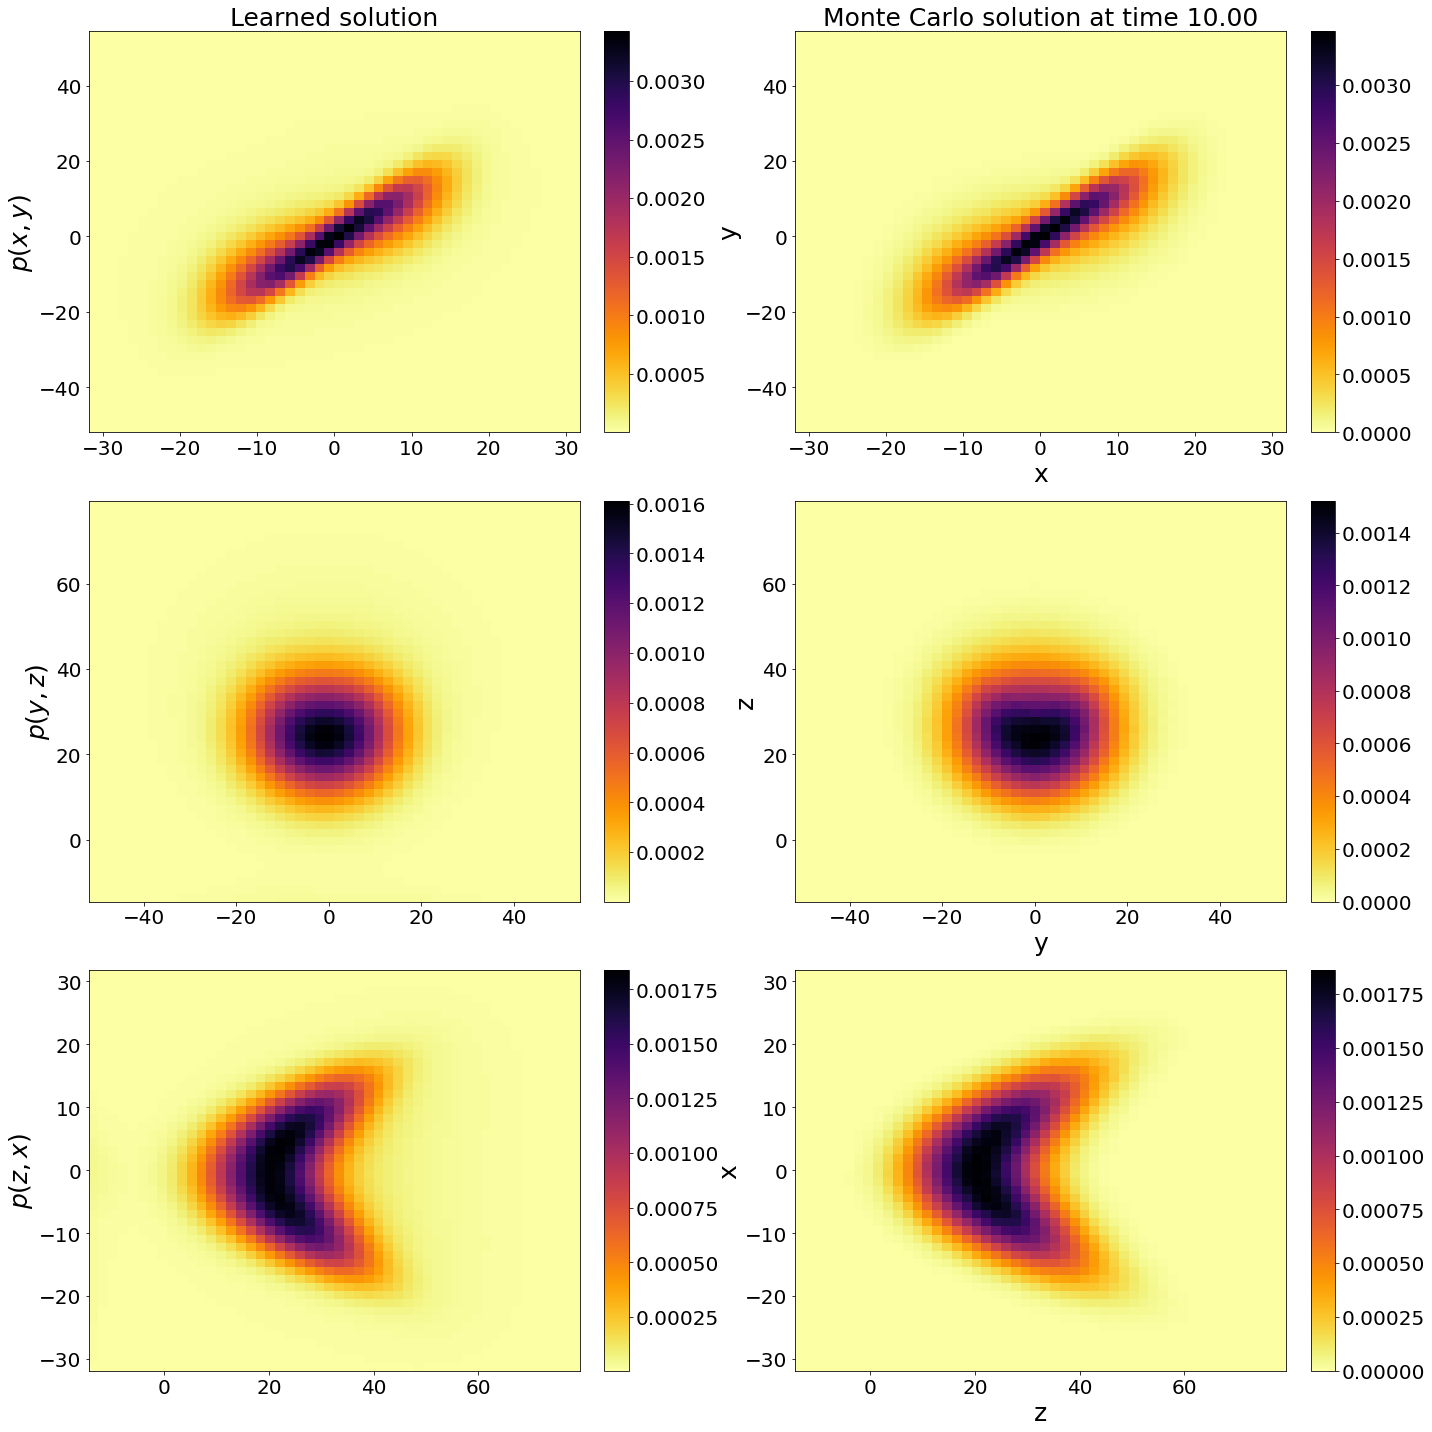

In [44]:
grid = mc_prob.get_grid()
low = grid.mins
high = grid.maxs
n_subdivs = n_subdivisions
n_int_subdivs = 100

x_ = np.linspace(low[0], high[0], num=n_subdivs, endpoint=True).astype('float32')
y_ = np.linspace(low[1], high[1], num=n_subdivs, endpoint=True).astype('float32')
z_ = np.linspace(low[2], high[2], num=n_subdivs, endpoint=True).astype('float32')

    
fig_all = plt.figure(figsize=(20, 20))
ax_1l = fig_all.add_subplot(321) 
ax_1m = fig_all.add_subplot(322)


ax_2l = fig_all.add_subplot(323) 
ax_2m = fig_all.add_subplot(324)

ax_3l = fig_all.add_subplot(325) 
ax_3m = fig_all.add_subplot(326)


div_1 = make_axes_locatable(ax_1l)
cax_1 = div_1.append_axes('right', '5%', '5%')
div_2 = make_axes_locatable(ax_2l)
cax_2 = div_2.append_axes('right', '5%', '5%')
div_3 = make_axes_locatable(ax_3l)
cax_3 = div_3.append_axes('right', '5%', '5%')

div_4 = make_axes_locatable(ax_1m)
cax_4 = div_4.append_axes('right', '5%', '5%')
div_5 = make_axes_locatable(ax_2m)
cax_5 = div_5.append_axes('right', '5%', '5%')
div_6 = make_axes_locatable(ax_3m)
cax_6 = div_6.append_axes('right', '5%', '5%')


z_m = mc_prob.compute_p2(0, 1, save=False)
z_m  /= (z_m.sum() * grid.h[0] * grid.h[1])
# y, x = np.meshgrid(y_, x_)
im = ax_1m.pcolormesh(x_, y_, z_m.T, cmap='inferno_r', shading='auto')
cbar = fig_all.colorbar(im, cax=cax_4, ax=ax_1m)
cbar.ax.tick_params(labelsize=cbar_tick_size)
#cbar.formatter.set_powerlimits((0, 0))
ax_1m.set_aspect("auto")

im = ax_2m.pcolormesh(y_, z_, mc_prob.compute_p2(1, 2, save=False).T, cmap='inferno_r', shading='auto')
cbar = fig_all.colorbar(im, cax=cax_5, ax=ax_2m)
cbar.ax.tick_params(labelsize=cbar_tick_size)
#cbar.formatter.set_powerlimits((0, 0))
ax_2m.set_aspect("auto")

im = ax_3m.pcolormesh(z_, x_, mc_prob.compute_p2(2, 0, save=False).T, cmap='inferno_r', shading='auto')
cbar = fig_all.colorbar(im, cax=cax_6, ax=ax_3m)
cbar.ax.tick_params(labelsize=cbar_tick_size)
#cbar.formatter.set_powerlimits((0, 0))
ax_3m.set_aspect("auto")

ax_1m.tick_params(axis='both', which='major', labelsize=tick_size)
ax_1m.tick_params(axis='both', which='minor', labelsize=tick_size)
ax_2m.tick_params(axis='both', which='major', labelsize=tick_size)
ax_2m.tick_params(axis='both', which='minor', labelsize=tick_size)
ax_3m.tick_params(axis='both', which='major', labelsize=tick_size)
ax_3m.tick_params(axis='both', which='minor', labelsize=tick_size)

ax_1m.set_title('Monte Carlo solution at time {:.2f}'.format(t), fontsize=title_size)
ax_1m.set_xlabel('x', fontsize=xlabel_size)
ax_1m.set_ylabel('y', fontsize=ylabel_size)
ax_2m.set_xlabel('y', fontsize=xlabel_size)
ax_2m.set_ylabel('z', fontsize=ylabel_size)
ax_3m.set_xlabel('z', fontsize=xlabel_size)
ax_3m.set_ylabel('x', fontsize=ylabel_size)




ax_1l.clear()
cax_1.cla()
z_1l = projector(net, low, high, [0, 1, 2], n_subdivs, n_int_subdivs)
im = ax_1l.pcolormesh(x_, y_, z_1l.T, cmap='inferno_r', shading='auto')
ax_1l.set_title('Learned solution', fontsize=title_size)
ax_1l.tick_params(axis='both', which='major', labelsize=tick_size)
ax_1l.tick_params(axis='both', which='minor', labelsize=tick_size)
cbar = fig_all.colorbar(im, cax=cax_1, ax=ax_1l)
cbar.ax.tick_params(labelsize=cbar_tick_size)
#cbar.formatter.set_powerlimits((0, 0))
ax_1l.set_aspect("auto")


# z_2l = fk.make_plot(n_steps, dt, n_repeats, 1, 2, 0)

ax_2l.clear()
cax_2.cla() 
z_2l = projector(net, low, high, [1, 2, 0], n_subdivs, n_int_subdivs)
im = ax_2l.pcolormesh(y_, z_, z_2l.T, cmap='inferno_r')
ax_2l.tick_params(axis='both', which='major', labelsize=tick_size)
ax_2l.tick_params(axis='both', which='minor', labelsize=tick_size)
cbar = fig_all.colorbar(im, cax=cax_2, ax=ax_2l)
cbar.ax.tick_params(labelsize=cbar_tick_size)
#cbar.formatter.set_powerlimits((0, 0))
ax_2l.set_aspect("auto")

# z_3l = fk.make_plot(n_steps, dt, n_repeats, 2, 0, 1)

ax_3l.clear()
cax_3.cla()
z_3l = projector(net, low, high, [2, 0, 1], n_subdivs, n_int_subdivs)
im = ax_3l.pcolormesh(z_, x_, z_3l.T, cmap='inferno_r')
ax_3l.tick_params(axis='both', which='major', labelsize=tick_size)
ax_3l.tick_params(axis='both', which='minor', labelsize=tick_size)
cbar = fig_all.colorbar(im, cax=cax_3, ax=ax_3l)
cbar.ax.tick_params(labelsize=cbar_tick_size)
# cbar.formatter.set_powerlimits((0, 0))
ax_3l.set_aspect("auto")
fig_all.subplots_adjust(wspace=0.5, hspace=0.4)

ax_1l.set_ylabel(r'$p(x, y)$', fontsize=ylabel_size)
ax_2l.set_ylabel(r'$p(y, z)$', fontsize=ylabel_size)
ax_3l.set_ylabel(r'$p(z, x)$', fontsize=ylabel_size)
plt.tight_layout()
plt.savefig('../../plots/L63.png')

<IPython.core.display.Javascript object>


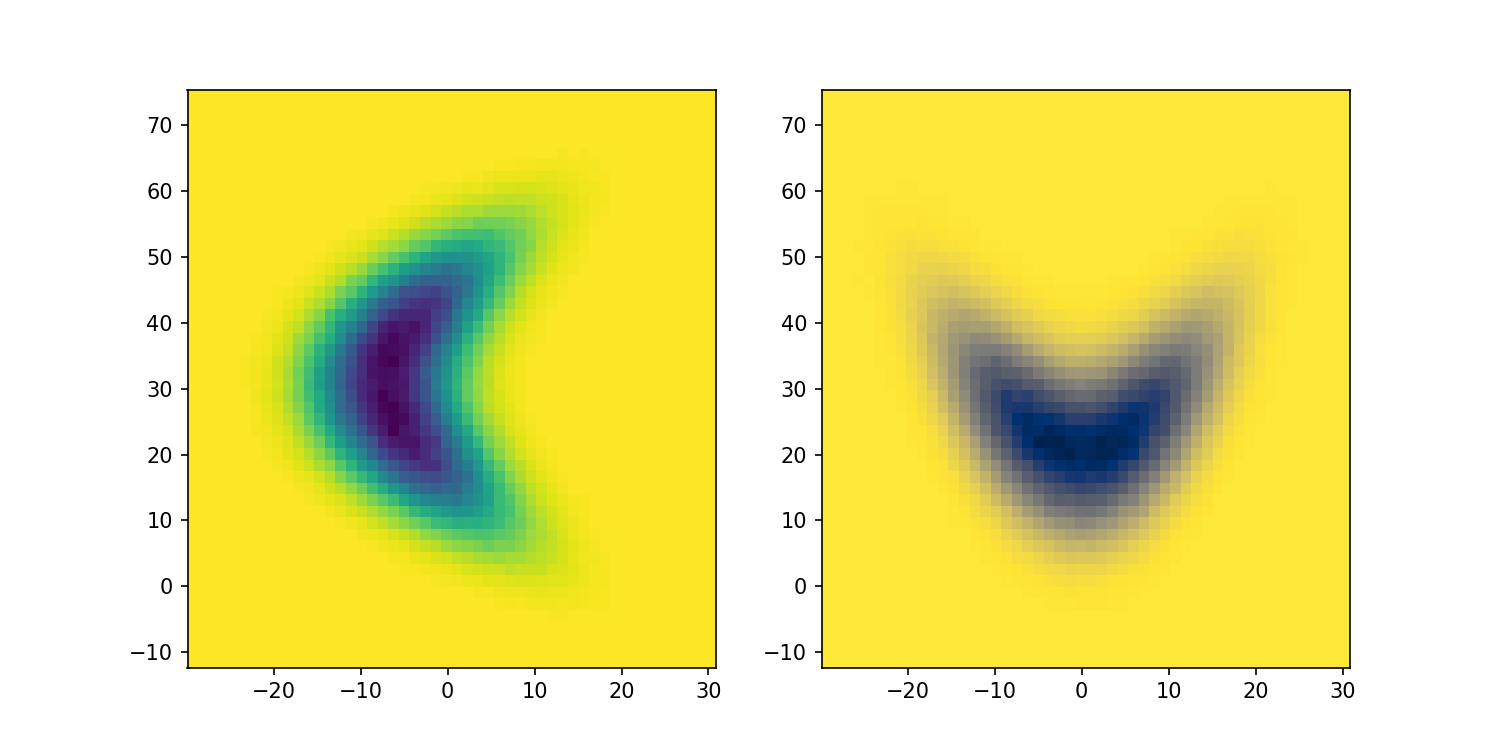

Time taken by compute_p2 is 3.034644842147827 seconds


In [7]:
fig_ = plt.figure(figsize=(10, 5))
ax = fig_.add_subplot(121)
ax_ = fig_.add_subplot(122)
z_m = mc_prob.compute_p2(2, 0, save=False)
z_m  /= (z_m.sum() * grid.h[0] * grid.h[1])
y, x = np.meshgrid(z_, x_)
ax.pcolormesh(x, y, z_m, cmap='viridis_r', shading='auto')
ax_.pcolormesh(x, y, z_m.T, cmap='cividis_r', shading='auto')
plt.show()

In [8]:
np.abs(z_m - z_m.T).sum()

0.3703877618622654

Time taken by compute_p2 is 2.9348816871643066 seconds


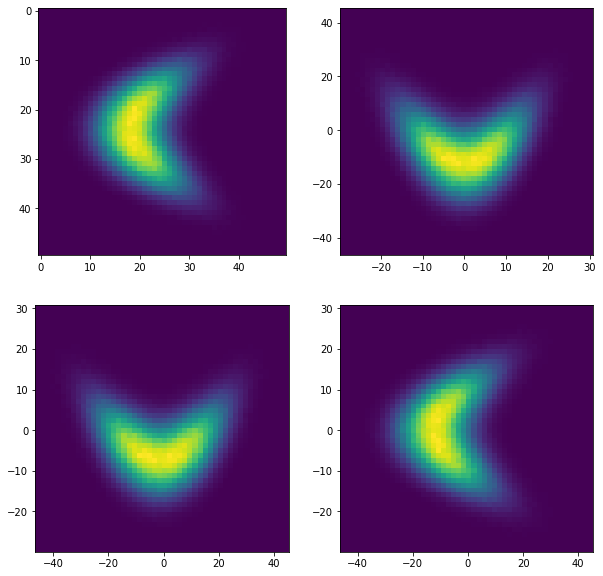

In [28]:
fig_ = plt.figure(figsize=(10, 10))
ax_1 = fig_.add_subplot(221)
ax_2 = fig_.add_subplot(222)
ax_3 = fig_.add_subplot(223)
ax_4 = fig_.add_subplot(224)
z_m = mc_prob.compute_p2(2, 0, save=False)
z_m  /= (z_m.sum() * grid.h[0] * grid.h[1])
y, x = np.meshgrid(y_, x_)
ax_1.imshow(z_m.T, cmap='viridis', origin='upper')
ax_2.pcolormesh(x, y, z_m.T, cmap='viridis', shading='auto')
ax_3.pcolormesh(y, x, z_m, cmap='viridis', shading='auto')
ax_4.pcolormesh(y, x, z_m.T, cmap='viridis', shading='auto')
plt.show()

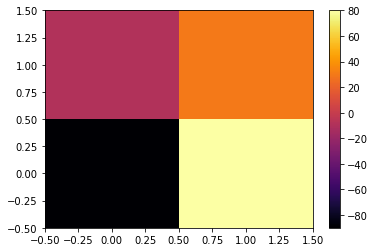

In [8]:
Z = np.array([[-90, -9], [80, 30]])
x = [0, 1]
y = [0, 1]
xx, yy = np.meshgrid(x, y)
cb = plt.pcolormesh(x, y, Z.T, cmap='inferno')
plt.colorbar(cb)
plt.show()